# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups               
Sample_053  P04004                          22.347
Sample_035  J3QS03;Q9GZX9                   17.437
Sample_144  Q8NFZ4                          16.033
Sample_100  A0AVL1;F8WC54;Q13443;Q13443-2   14.955
Sample_145  E9PL83;P35318                   16.679
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups            
Sample_075  A0A0C4DGV8;Q13214;Q13214-2   14.796
Sample_018  F5GWQ8;J3QKW8;Q15846         16.920
Sample_090  A0A0G2JRN3                   21.251
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.720
            A0A075B6Q5                 12.483
            A0A075B6R2                 11.696
            A0A075B6S5                 13.533
            A0A087WSY4                 14.613
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.049
            Q9UI40;Q9UI40-2            12.497
            Q9UIW2                     13.152
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.047
            Q9UP79                     13.031
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.244,15.050,16.842,19.863,16.503,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.610,19.067,...,15.528,15.576,13.987,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.205,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.155,17.705,17.039,15.693,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,14.572,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.799,15.345,17.084,18.708,14.249,19.433,11.530,10.599
Sample_207,15.739,16.877,15.469,16.898,13.497,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.752,12.162,13.551,10.973,12.198,12.992,11.997,12.515,11.608,12.739
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.754,19.067,16.127,...,12.230,12.343,13.721,12.599,12.710,12.570,13.625,12.877,10.964,12.305
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.205,12.924,13.063,13.034,12.708,12.022,12.888,14.688,12.486,13.283
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.867,12.721,13.165,14.650,13.325,13.128,12.391,13.128,14.050,12.936
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.133,12.912,13.055,11.816,12.128,13.367,11.465,12.801,11.862,13.813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.305,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 403.76it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.80it/s]

100%|██████████| 2/2 [00:00<00:00,  7.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.85it/s]

100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.51it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.40it/s]

100%|██████████| 4/4 [00:00<00:00,  4.45it/s]

100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.33it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.40it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.45it/s]

100%|██████████| 5/5 [00:01<00:00,  4.27it/s]

100%|██████████| 5/5 [00:01<00:00,  4.66it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.95it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.65it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.34it/s]

100%|██████████| 6/6 [00:01<00:00,  4.13it/s]

100%|██████████| 6/6 [00:01<00:00,  4.59it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.48it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.79it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.28it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.79it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.81it/s]

100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.19it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.50it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.39it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.11it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.03it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.82it/s]

100%|██████████| 8/8 [00:01<00:00,  3.79it/s]

100%|██████████| 8/8 [00:01<00:00,  4.20it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.10it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.34it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.82it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.47it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.25it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.00it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.86it/s]

100%|██████████| 9/9 [00:02<00:00,  3.63it/s]

100%|██████████| 9/9 [00:02<00:00,  4.16it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.27it/s]

 30%|███       | 3/10 [00:00<00:01,  4.80it/s]

 40%|████      | 4/10 [00:00<00:01,  4.57it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.29it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.16it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.92it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.91it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.68it/s]

100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.77it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.31it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.86it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.41it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.11it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.83it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.76it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.69it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.78it/s]

100%|██████████| 11/11 [00:02<00:00,  4.10it/s]

100%|██████████| 11/11 [00:02<00:00,  4.21it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.02it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.12it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.98it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.60it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.17it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.29it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.11it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.11it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.08it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.97it/s]

100%|██████████| 12/12 [00:02<00:00,  4.01it/s]

100%|██████████| 12/12 [00:02<00:00,  4.31it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.17it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.04it/s]

 31%|███       | 4/13 [00:00<00:02,  3.84it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.45it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.21it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.11it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.88it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.94it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.93it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.59it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.58it/s]

100%|██████████| 13/13 [00:04<00:00,  2.63it/s]

100%|██████████| 13/13 [00:04<00:00,  3.01it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.96it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.96it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.63it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.40it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.47it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.51it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.38it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.24it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.33it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.40it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.20it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.39it/s]

100%|██████████| 14/14 [00:03<00:00,  3.64it/s]

100%|██████████| 14/14 [00:03<00:00,  3.52it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.72it/s]

 20%|██        | 3/15 [00:00<00:02,  4.83it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.40it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.87it/s]

 40%|████      | 6/15 [00:01<00:02,  3.36it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.27it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.00it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.90it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.81it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.03it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.23it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.38it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.31it/s]

100%|██████████| 15/15 [00:04<00:00,  3.51it/s]

100%|██████████| 15/15 [00:04<00:00,  3.43it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.034 0.009          0.766 0.340       0.113   
2             0.003 0.000      0.035 0.000          0.647 0.097       0.559   
3             0.003 0.000      0.035 0.000          0.692 0.112       0.655   
4             0.003 0.000      0.034 0.002          0.695 0.102       0.649   
5             0.003 0.000      0.035 0.000          0.759 0.103       0.716   
6             0.003 0.000      0.035 0.000          0.784 0.091       0.793   
7             0.003 0.000      0.035 0.001          0.783 0.089       0.791   
8             0.003 0.000      0.035 0.001          0.819 0.096       0.786   
9             0.004 0.001      0.036 0.005          0.833 0.091       0.818   
10            0.003 0.001      0.035 0.004          0.828 0.093       0.823   
11            0.003 0.000      0.032 0.002          0.825 0.088       0.819   
12            0.004 0.002      0.032 0.005          0.822 0.090       0.818   
13            0.004 0.002      0.042 0.016          0.813 0.088       0.822   
14            0.005 0.003      0.044 0.015          0.819 0.088       0.818   
15            0.004 0.003      0.038 0.010          0.813 0.090       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.190 0.123                  0.549 0.039        0.851   
2          0.123   0.594 0.099                  0.668 0.069        0.754   
3          0.141   0.666 0.108                  0.719 0.084        0.799   
4          0.139   0.664 0.103                  0.719 0.079        0.802   
5          0.108   0.731 0.082                  0.772 0.069        0.832   
6          0.124   0.783 0.083                  0.815 0.070        0.896   
7          0.120   0.781 0.082                  0.814 0.069        0.893   
8          0.113   0.796 0.077                  0.827 0.063        0.898   
9          0.105   0.822 0.079                  0.848 0.068        0.915   
10         0.104   0.821 0.079                  0.847 0.068        0.916   
11         0.103   0.818 0.076                  0.845 0.065        0.914   
12         0.103   0.816 0.077                  0.843 0.066        0.913   
13         0.104   0.813 0.075                  0.840 0.065        0.912   
14         0.092   0.815 0.069                  0.841 0.059        0.916   
15         0.093   0.808 0.071                  0.835 0.062        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.824 0.088        210.000 0.000  
2          0.070                  0.720 0.082        210.000 0.000  
3          0.073                  0.761 0.096        210.000 0.000  
4          0.075                  0.760 0.099        210.000 0.000  
5          0.071                  0.806 0.084        210.000 0.000  
6          0.054                  0.875 0.061        210.000 0.000  
7          0.055                  0.872 0.063        210.000 0.000  
8          0.052                  0.868 0.068        210.000 0.000  
9          0.051                  0.898 0.059        210.000 0.000  
10         0.052                  0.900 0.060        210.000 0.000  
11         0.053                  0.898 0.061        210.000 0.000  
12         0.053                  0.897 0.061        210.000 0.000  
13         0.053                  0.896 0.060        210.000 0.000  
14         0.052                  0.902 0.057        210.000 0.000  
15         0.052                  0.901 0.058 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 510.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.86it/s]

100%|██████████| 3/3 [00:00<00:00,  2.93it/s]

100%|██████████| 3/3 [00:00<00:00,  3.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.76it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.68it/s]

100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.94it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.51it/s]

100%|██████████| 5/5 [00:01<00:00,  2.75it/s]

100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.00it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.94it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.48it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.38it/s]

100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

100%|██████████| 6/6 [00:01<00:00,  3.52it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.92it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.43it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.14it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.18it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.93it/s]

100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

100%|██████████| 7/7 [00:02<00:00,  3.17it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.20it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.38it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.98it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.88it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.49it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.47it/s]

100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

100%|██████████| 8/8 [00:02<00:00,  3.75it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.69it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.35it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.83it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.98it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.16it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.29it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.22it/s]

100%|██████████| 9/9 [00:02<00:00,  3.25it/s]

100%|██████████| 9/9 [00:02<00:00,  3.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.50it/s]

 30%|███       | 3/10 [00:00<00:02,  3.23it/s]

 40%|████      | 4/10 [00:01<00:02,  2.89it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.70it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.71it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.77it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.81it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.92it/s]

100%|██████████| 10/10 [00:03<00:00,  3.03it/s]

100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.41it/s]

 27%|██▋       | 3/11 [00:00<00:02,  2.96it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.48it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.34it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.29it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.47it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.77it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.80it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.99it/s]

100%|██████████| 11/11 [00:03<00:00,  3.03it/s]

100%|██████████| 11/11 [00:03<00:00,  2.79it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.91it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.36it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.85it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.68it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.44it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.45it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.50it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.60it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.77it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.90it/s]

100%|██████████| 12/12 [00:04<00:00,  3.01it/s]

100%|██████████| 12/12 [00:04<00:00,  2.83it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.62it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.47it/s]

 31%|███       | 4/13 [00:01<00:02,  3.19it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.94it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.80it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.90it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.96it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.03it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.84it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.62it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.49it/s]

100%|██████████| 13/13 [00:04<00:00,  2.32it/s]

100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.65it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.73it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.48it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.52it/s]

 43%|████▎     | 6/14 [00:02<00:02,  2.76it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.65it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.73it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  3.02it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.13it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.19it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  3.16it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  3.15it/s]

100%|██████████| 14/14 [00:04<00:00,  2.80it/s]

100%|██████████| 14/14 [00:04<00:00,  2.87it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.15it/s]

 20%|██        | 3/15 [00:00<00:03,  3.67it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.64it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.31it/s]

 40%|████      | 6/15 [00:02<00:04,  2.21it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.19it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.19it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.42it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.60it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.56it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.64it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.84it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.99it/s]

100%|██████████| 15/15 [00:05<00:00,  3.03it/s]

100%|██████████| 15/15 [00:05<00:00,  2.69it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.037 0.008          0.120 0.291       0.014   
2             0.003 0.001      0.040 0.016          0.817 0.080       0.708   
3             0.004 0.002      0.045 0.021          0.827 0.095       0.731   
4             0.003 0.002      0.047 0.020          0.803 0.096       0.770   
5             0.005 0.004      0.044 0.014          0.792 0.094       0.750   
6             0.005 0.006      0.048 0.017          0.791 0.095       0.752   
7             0.005 0.005      0.052 0.020          0.798 0.089       0.781   
8             0.004 0.003      0.047 0.016          0.805 0.097       0.802   
9             0.005 0.003      0.048 0.019          0.807 0.096       0.800   
10            0.005 0.004      0.048 0.016          0.805 0.089       0.812   
11            0.005 0.005      0.054 0.018          0.821 0.089       0.808   
12            0.004 0.003      0.047 0.017          0.834 0.080       0.833   
13            0.004 0.004      0.045 0.019          0.832 0.082       0.830   
14            0.008 0.008      0.053 0.021          0.815 0.086       0.808   
15            0.005 0.003      0.045 0.016          0.819 0.085       0.813   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.039   0.024 0.064                  0.503 0.017        0.862   
2          0.120   0.753 0.089                  0.796 0.066        0.870   
3          0.119   0.769 0.087                  0.807 0.066        0.889   
4          0.114   0.780 0.079                  0.813 0.065        0.901   
5          0.117   0.764 0.080                  0.800 0.065        0.898   
6          0.114   0.764 0.077                  0.800 0.062        0.895   
7          0.109   0.785 0.079                  0.817 0.067        0.901   
8          0.100   0.798 0.071                  0.827 0.060        0.905   
9          0.103   0.798 0.074                  0.827 0.063        0.902   
10         0.108   0.803 0.074                  0.832 0.062        0.910   
11         0.105   0.810 0.074                  0.838 0.063        0.913   
12         0.105   0.829 0.071                  0.855 0.061        0.919   
13         0.106   0.826 0.071                  0.852 0.061        0.918   
14         0.098   0.807 0.072                  0.836 0.061        0.922   
15         0.097   0.812 0.071                  0.839 0.061        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.830 0.085        210.000 0.000  
2          0.062                  0.853 0.074        210.000 0.000  
3          0.053                  0.868 0.069        210.000 0.000  
4          0.052                  0.884 0.059        210.000 0.000  
5          0.052                  0.880 0.059        210.000 0.000  
6          0.053                  0.877 0.063        210.000 0.000  
7          0.051                  0.880 0.061        210.000 0.000  
8          0.050                  0.886 0.058        210.000 0.000  
9          0.051                  0.882 0.059        210.000 0.000  
10         0.048                  0.889 0.055        210.000 0.000  
11         0.047                  0.894 0.055        210.000 0.000  
12         0.047                  0.903 0.053        210.000 0.000  
13         0.047                  0.901 0.053        210.000 0.000  
14         0.042                  0.907 0.048        210.000 0.000  
15         0.042                  0.906 0.048 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1035.12it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 31.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.78it/s]

100%|██████████| 3/3 [00:00<00:00, 18.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 22.10it/s]

100%|██████████| 4/4 [00:00<00:00, 18.74it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 18.58it/s]

100%|██████████| 5/5 [00:00<00:00, 16.54it/s]

100%|██████████| 5/5 [00:00<00:00, 16.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.41it/s]

100%|██████████| 6/6 [00:00<00:00, 14.06it/s]

100%|██████████| 6/6 [00:00<00:00, 14.42it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 21.26it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 14.04it/s]

100%|██████████| 7/7 [00:00<00:00, 13.17it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 20.76it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.21it/s]

100%|██████████| 8/8 [00:00<00:00, 12.98it/s]

100%|██████████| 8/8 [00:00<00:00, 13.79it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.29it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 14.82it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 13.66it/s]

100%|██████████| 9/9 [00:00<00:00, 13.74it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.13it/s]

 50%|█████     | 5/10 [00:00<00:00, 14.25it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.46it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.33it/s]

100%|██████████| 10/10 [00:00<00:00, 11.95it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.15it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.79it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.31it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.86it/s]

100%|██████████| 11/11 [00:00<00:00, 12.54it/s]

100%|██████████| 11/11 [00:00<00:00, 13.00it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.19it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.89it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.53it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.37it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.99it/s]

100%|██████████| 12/12 [00:00<00:00, 12.59it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 20.57it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.00it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 15.96it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.94it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.78it/s]

100%|██████████| 13/13 [00:00<00:00, 14.95it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.28it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.84it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.84it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.61it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.14it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.37it/s]

100%|██████████| 14/14 [00:01<00:00, 12.84it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.43it/s]

 40%|████      | 6/15 [00:00<00:00, 12.73it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.35it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.57it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.08it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 13.32it/s]

100%|██████████| 15/15 [00:01<00:00, 13.44it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.041 0.012          0.000 0.000       0.000   
2             0.005 0.004      0.049 0.019          0.624 0.124       0.486   
3             0.004 0.002      0.044 0.019          0.681 0.096       0.595   
4             0.005 0.004      0.054 0.020          0.682 0.104       0.582   
5             0.004 0.002      0.039 0.010          0.691 0.079       0.628   
6             0.005 0.005      0.066 0.025          0.673 0.093       0.617   
7             0.004 0.003      0.047 0.030          0.665 0.082       0.630   
8             0.005 0.005      0.068 0.026          0.667 0.087       0.627   
9             0.006 0.005      0.049 0.017          0.660 0.086       0.625   
10            0.007 0.006      0.056 0.022          0.656 0.089       0.638   
11            0.003 0.000      0.036 0.005          0.656 0.090       0.644   
12            0.006 0.006      0.061 0.032          0.654 0.087       0.643   
13            0.006 0.006      0.061 0.025          0.652 0.079       0.643   
14            0.006 0.005      0.056 0.022          0.647 0.092       0.613   
15            0.004 0.002      0.040 0.014          0.635 0.093       0.595   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.754   
2          0.132   0.536 0.107                  0.632 0.069        0.707   
3          0.099   0.631 0.085                  0.694 0.066        0.793   
4          0.096   0.622 0.081                  0.688 0.063        0.792   
5          0.106   0.653 0.080                  0.711 0.061        0.800   
6          0.105   0.638 0.083                  0.697 0.064        0.797   
7          0.119   0.641 0.087                  0.698 0.064        0.799   
8          0.113   0.640 0.084                  0.697 0.065        0.796   
9          0.105   0.636 0.075                  0.692 0.061        0.800   
10         0.118   0.642 0.090                  0.697 0.073        0.804   
11         0.118   0.645 0.090                  0.698 0.073        0.801   
12         0.116   0.645 0.090                  0.698 0.073        0.800   
13         0.111   0.643 0.079                  0.696 0.064        0.796   
14         0.116   0.624 0.090                  0.684 0.070        0.796   
15         0.117   0.609 0.094                  0.672 0.071        0.797   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.701 0.082        210.000 0.000  
2          0.079                  0.627 0.090        210.000 0.000  
3          0.064                  0.721 0.084        210.000 0.000  
4          0.062                  0.719 0.082        210.000 0.000  
5          0.058                  0.734 0.079        210.000 0.000  
6          0.060                  0.726 0.082        210.000 0.000  
7          0.057                  0.729 0.081        210.000 0.000  
8          0.062                  0.727 0.083        210.000 0.000  
9          0.059                  0.733 0.075        210.000 0.000  
10         0.058                  0.745 0.074        210.000 0.000  
11         0.059                  0.741 0.075        210.000 0.000  
12         0.058                  0.738 0.074        210.000 0.000  
13         0.059                  0.736 0.073        210.000 0.000  
14         0.060                  0.734 0.074        210.000 0.000  
15         0.058                  0.735 0.073 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,14,10
score_time,14,11,8
test_precision,9,12,5
test_recall,10,12,11
test_f1,9,12,5
test_balanced_accuracy,9,12,5
test_roc_auc,10,14,10
test_average_precision,14,14,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.33it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.38it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.97it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.53it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.36it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.14it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.20it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.29it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.41it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.51it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.66it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.73it/s]

100%|██████████| 14/14 [00:05<00:00,  2.85it/s]

100%|██████████| 14/14 [00:05<00:00,  2.67it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.98it/s]

 60%|██████    | 6/10 [00:00<00:00, 17.38it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.42it/s]

100%|██████████| 10/10 [00:00<00:00, 13.27it/s]

100%|██████████| 10/10 [00:00<00:00, 14.53it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.73it/s]

 30%|███       | 3/10 [00:00<00:02,  2.98it/s]

 40%|████      | 4/10 [00:01<00:02,  2.58it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.34it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.26it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.32it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.57it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.61it/s]

100%|██████████| 10/10 [00:03<00:00,  2.71it/s]

100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


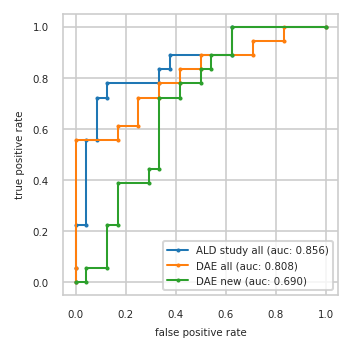

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.222   0.000 0.556   0.042 0.056
3          0.042 0.222   0.167 0.556   0.125 0.056
4          0.042 0.556   0.167 0.611   0.125 0.222
5          0.083 0.556   0.250 0.611   0.167 0.222
6          0.083 0.722   0.250 0.722   0.167 0.389
7          0.125 0.722   0.333 0.722   0.292 0.389
8          0.125 0.778   0.333 0.778   0.292 0.444
9          0.333 0.778   0.417 0.778   0.333 0.444
10         0.333 0.833   0.417 0.833   0.333 0.722
11         0.375 0.833   0.500 0.833   0.417 0.722
12         0.375 0.889   0.500 0.889   0.417 0.778
13         0.625 0.889   0.708 0.889   0.500 0.778
14         0.625 1.000   0.708 0.944   0.500 0.833
15         1.000 1.000   0.833 0.944   0.542 0.833
16           NaN   NaN   0.833 1.000   0.542 0.889
17           NaN   NaN   1.000 1.000   0.625 0.889
18           NaN   NaN     NaN   NaN   0.625 1.000
19           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P00740;P00740-2,Q9NX62,H0Y7C8;O14657
2,Q9NR34,Q99983,P51688
3,Q13231;Q13231-3,P14174,P31321
4,P04075,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P61981,Q9Y2T3;Q9Y2T3-3,P01743
6,C9JF17;P05090,P04075,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
7,P14174,Q14894,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6
8,P18428,P63104,Q96GD0


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


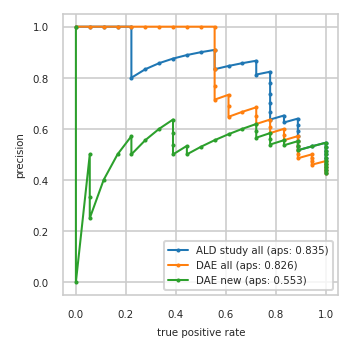

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.459 0.944     0.486 1.000
6          0.500 1.000     0.472 0.944     0.500 1.000
7          0.514 1.000     0.486 0.944     0.514 1.000
8          0.529 1.000     0.500 0.944     0.529 1.000
9          0.545 1.000     0.485 0.889     0.545 1.000
10         0.531 0.944     0.500 0.889     0.531 0.944
11         0.516 0.889     0.516 0.889     0.516 0.889
12         0.533 0.889     0.533 0.889     0.533 0.889
13         0.552 0.889     0.552 0.889     0.552 0.889
14         0.571 0.889     0.571 0.889     0.536 0.833
15         0.593 0.889     0.556 0.833     0.556 0.833
16         0.615 0.889     0.577 0.833     0.538 0.778
17         0.640 0.889     0.600 0.833     0.560 0.778
18         0.625 0.833     0.583 0.778     0.583 0.778
19         0.652 0.833     0.609 0.778     0.565 0.722
20         0.636 0.778     0.636 0.778     0.591 0.722
21         0.667 0.778     0.619 0.722     0.619 0.722
22         0.700 0.778     0.650 0.722     0.600 0.667
23         0.737 0.778     0.684 0.722     0.579 0.611
24         0.778 0.778     0.667 0.667     0.556 0.556
25         0.824 0.778     0.647 0.611     0.529 0.500
26         0.812 0.722     0.688 0.611     0.500 0.444
27         0.867 0.722     0.733 0.611     0.533 0.444
28         0.857 0.667     0.714 0.556     0.500 0.389
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.833 0.556     0.833 0.556     0.583 0.389
31         0.909 0.556     0.909 0.556     0.636 0.389
32         0.900 0.500     1.000 0.556     0.600 0.333
33         0.889 0.444     1.000 0.500     0.556 0.278
34         0.875 0.389     1.000 0.444     0.500 0.222
35         0.857 0.333     1.000 0.389     0.571 0.222
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


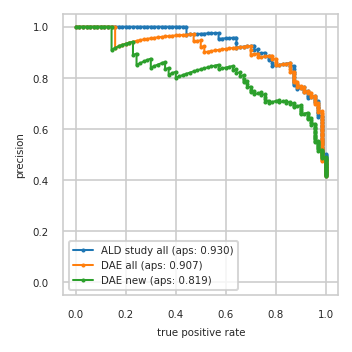

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


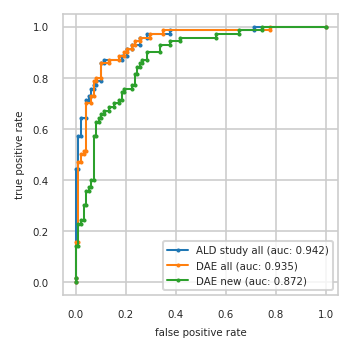

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}